In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
from NN_Models import LogisticRegressionSplit
from preprocessing import for_kaggle
from evaluation import predict, LogisticRegressionPredictModel

import json
import numpy as np
import pandas as pd
import torch
import time
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# year & venue
f = open("outputs/year_venue.json", 'r')
year_venue = json.load(f)

f = open("outputs/year_venue_all.json", 'r')
year_venue_all = json.load(f)

# abstract & title
f = open("outputs/abstract_title.json", 'r')
abstracts_title = json.load(f)

f = open("outputs/abstract_title_all.json", 'r')
abstracts_title_all = json.load(f)

# coauthor
f = open("outputs/author.json", 'r')
author = json.load(f)

f = open("outputs/author_all.json", 'r')
author_all = json.load(f)

# label
y_all = torch.load('data/y_all.pt')

## Weighted

In [10]:
#################################
# weight_sentence = 0.31982275074419797  # abstracts - title
# weight_author = 0.6143938170885868  # authors
# weight_year_venue = 0.09287086258899986  # year - venue

# sum_ = weight_author + weight_sentence + weight_year_venue
#################################

# YEAR_VENUE_WEIGHT = weight_year_venue/sum_
# COAUTHOR_WEIGHT = weight_author/sum_
# SENTENCE_WEIGHT = weight_sentence/sum_    

COAUTHOR_WEIGHT = 0.4736842105
YEAR_VENUE_WEIGHT = 0.0526315789
SENTENCE_WEIGHT = 0.4736842105

In [22]:
THRESHOLD = 0.2

kaggle_predict = predict(
            author=author,
            year_venue=year_venue,
            abstracts_title=abstracts_title,
            YEAR_VENUE_WEIGHT=YEAR_VENUE_WEIGHT,
            COAUTHOR_WEIGHT=COAUTHOR_WEIGHT,
            SENTENCE_WEIGHT=SENTENCE_WEIGHT,
            THRESHOLD=THRESHOLD
        )

In [23]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_weighted_hhh.csv")

## Logistic Regression Model

In [11]:
clf = LogisticRegressionPredictModel()
clf.train(author_all, year_venue_all, abstracts_title_all, y_all)

100%|██████████| 9354/9354 [00:05<00:00, 1729.99it/s]


Score :  1.0


LogisticRegression(random_state=0)

In [12]:
kaggle_predict = clf.evaluation(author, year_venue, abstracts_title)

100%|██████████| 800/800 [00:05<00:00, 138.30it/s]


In [13]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_LR.csv")

## Election

In [55]:
THRESHOLD_YV = 0.4
THRESHOLD_AU = 0.6
THRESHOLD_AT = 0.2

kaggle_predict = []

for i in range(800):
    
    preds_dict = {}
    
    for j in range(100):

        # year & venue
        yv = year_venue[str(i)][str(j)]
        
        if yv >= THRESHOLD_YV:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

        # author
        au = author[str(i)][str(j)]
        
        if au >= THRESHOLD_AU:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

        # abstract & title
        at = abstracts_title[str(i)][str(j)]
        
        if at >= THRESHOLD_AT:
            if j in preds_dict:
                preds_dict[j] += 1
            else:
                preds_dict[j] = 1

    pred = ""
    for au in preds_dict.keys():
        if preds_dict[au] >= 1:
            pred += str(au) + " "

    if pred:
        kaggle_predict.append(pred[:-1])
    else:
        kaggle_predict.append("-1")

        

In [56]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_election.csv")

## Prediction Describe

In [20]:
count = 0
for i in kaggle['Predict']:
    if i == '-1':
        count += 1

print('proportion of no authors  : ', count/800)
print('number of having prolific authors  : ', 800-count)

proportion of no authors  :  0.25
number of having prolific authors  :  600


In [21]:
kaggle.head()

,Predict
ID,
0,92
1,2 12
2,31
3,23
4,-1


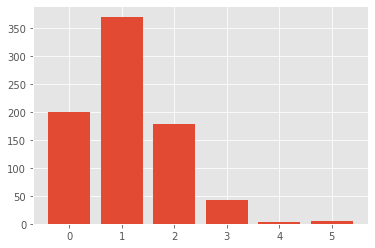

In [19]:
from matplotlib import pyplot as plt

counts = {}
for i in kaggle['Predict']:
    if i == '-1':
        if 0 in counts:
            counts[0] += 1
        else:
            counts[0] = 1
        continue

    num_author = len(i.split())
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 32653.70it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


100%|██████████| 9354/9354 [00:02<00:00, 3405.39it/s]


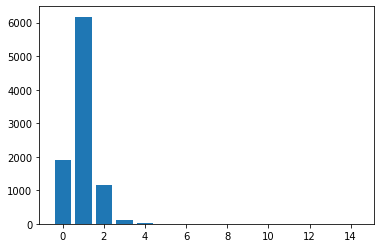

In [46]:
from preprocessing import for_train
X, y = for_train("year_venue", p=0.20250)

counts = {}
for i in tqdm(y):
    num_author = sum(i).item()
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()

In [73]:
kaggle

,Predict
ID,
0,1 10 92
1,1 2
2,31
3,6 23
4,-1
...,...
795,1 54
796,97
797,13 71


# Kaggle Predictions

- YEAR_VENUE_WEIGHT = 1/3
- COAUTHOR_WEIGHT = 1/3
- SENTENCE_WEIGHT = 1/3
    - f1 = 0.47230

# Kaggle Predictions - 2

- YEAR_VENUE_WEIGHT = 0.08884680485159918.
- COAUTHOR_WEIGHT = 0.5925861815691253
- SENTENCE_WEIGHT = 0.3185670135792754
    - f1 = 0.52080

In [21]:
print(YEAR_VENUE_WEIGHT)
print(COAUTHOR_WEIGHT)
print(SENTENCE_WEIGHT)

0.09042157448160128
0.5981903768759776
0.31138804864242114


# Kaggle Predictions - Weighted （best）

- YEAR_VENUE_WEIGHT = 0.09042157448160128
- COAUTHOR_WEIGHT = 0.5981903768759776
- SENTENCE_WEIGHT = 0.31138804864242114
- THRESHOLD = 0.2
    - f1 = 0.56880

# Kaggle Predictions - Weighted

- YEAR_VENUE_WEIGHT = 0.08346672643333612
- COAUTHOR_WEIGHT = 0.586237115452411
- SENTENCE_WEIGHT = 0.3302961581142529
- THRESHOLD = 0.2
    - f1 = 0.54747

# Kaggle Predictions - 3

- YEAR_VENUE_WEIGHT = 0.09421771031395267.
- COAUTHOR_WEIGHT = 0.43393907367832263
- SENTENCE_WEIGHT = 0.4718432160077247
- THRESHOLD = 0.3
    - f1 = 0.53130